In [1]:
!pip install tensorflow

You should consider upgrading via the '/home/dmitrypogrebnoy/Desktop/AdvancedML_ITMO_Cource_2/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

2022-10-08 12:24:51.877769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 12:24:52.028042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 12:24:52.028068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-08 12:24:52.054395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 12:24:52.821239: W tensorflow/stream_executor/platform/de

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


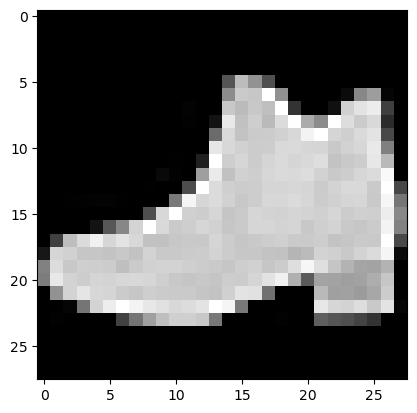

In [5]:
plt.imshow(X_train[15], cmap="gray")

In [6]:
params = {
    'input_size' : 28 * 28 * 1,
    'num_pic_class' : 10,
    'encoder_layers': [256],
    'decoder_layers': [256],
    'pic_classification_layers': [256],   # for conditions
    'activation': tf.nn.sigmoid,
    'decoder_std': 0.5,                     # std for P(x|z)
    'z_dim': 10,                            # latent space dimension
    'pic_classification_weight': 10.0,    # for conditions
    'epochs': 50,
    'batch_size': 50,
    'learning_rate': 0.0005
}

In [7]:
def encoder(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.compat.v1.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.compat.v1.layers.dense(z,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(z, params['input_size'])
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    logits = tf.compat.v1.layers.dense(x, params['num_pic_class'])
    return logits


# sample the vector from latent space, using
# reparametrization
images = tf.compat.v1.placeholder(tf.float32, [None, params['input_size']])
pic_res = tf.compat.v1.placeholder(tf.int32, [None])
# encode the image into latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])
eps = tf.compat.v1.random_normal(shape=[tf.shape(images)[0],
                                        params['z_dim']],
                                 mean=0.0,
                                 stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
pic_logits = digit_classifier(images,
                                params['pic_classification_layers'])
pic_prob = tf.nn.softmax(pic_logits)

# decode latent vector using digit classification condition into the image
decoded_images = decoder(tf.concat([z, pic_prob], axis=1),
                         params['decoder_layers'])

/tmp/ipykernel_25895/3662823629.py:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(x,
/tmp/ipykernel_25895/3662823629.py:6: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mu = tf.compat.v1.layers.dense(x, params['z_dim'])
/tmp/ipykernel_25895/3662823629.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  var = 1e-5 + tf.exp(tf.compat.v1.layers.dense(x, params['z_dim']))
/tmp/ipykernel_25895/3662823629.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.compat.v1.layers.dense(x,
/tmp/ipykernel_25895/3662823629.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use

In [8]:
# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.compat.v1.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.compat.v1.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_digit_classifier = params['pic_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=pic_res,
                                                   logits=pic_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_digit_classifier

train_op = tf.compat.v1.train.AdamOptimizer(params['learning_rate']).minimize(loss)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [9]:
# Training
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        n_minibatches = int(X_train.shape[0] / params['batch_size'])
        print("Number of minibatches: ", n_minibatches)
        for i in range(n_minibatches):
            # batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            batch_images = X_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_pic_res = y_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_images = np.reshape(batch_images, (params['batch_size'], params['input_size']))
            batch_pic_res = np.reshape(batch_pic_res, (params['batch_size'],))
            sess.run(train_op, feed_dict={images: batch_images, pic_res: batch_pic_res})


        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: np.reshape(X_train, (X_train.shape[0], params['input_size'])),
             pic_res: np.reshape(y_train, (y_train.shape[0], )) })

        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)

        print(f"Loss: {train_loss_auto_encode + train_loss_digit_classifier}")

        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[params['num_pic_class'], 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, pic_prob: np.eye(params['num_pic_class'])})
        samples.append(gen_samples)

print("\nTraining completed!")


2022-10-08 12:24:55.342122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 12:24:55.342652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 12:24:55.342790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-08 12:24:55.342900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-08 12:24:55.343004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch # -  0
Number of minibatches:  1200
Loss: 241.51612854003906
Epoch # -  1
Number of minibatches:  1200
Loss: 232.8159637451172
Epoch # -  2
Number of minibatches:  1200
Loss: 229.3128662109375
Epoch # -  3
Number of minibatches:  1200
Loss: 227.16807556152344
Epoch # -  4
Number of minibatches:  1200
Loss: 225.6701202392578
Epoch # -  5
Number of minibatches:  1200
Loss: 224.8551483154297
Epoch # -  6
Number of minibatches:  1200
Loss: 223.97508239746094
Epoch # -  7
Number of minibatches:  1200
Loss: 223.3130340576172
Epoch # -  8
Number of minibatches:  1200
Loss: 222.54940795898438
Epoch # -  9
Number of minibatches:  1200
Loss: 221.9110107421875
Epoch # -  10
Number of minibatches:  1200
Loss: 221.3486785888672
Epoch # -  11
Number of minibatches:  1200
Loss: 220.6300048828125
Epoch # -  12
Number of minibatches:  1200
Loss: 220.26768493652344
Epoch # -  13
Number of minibatches:  1200
Loss: 219.79933166503906
Epoch # -  14
Number of minibatches:  1200
Loss: 219.4915008544922

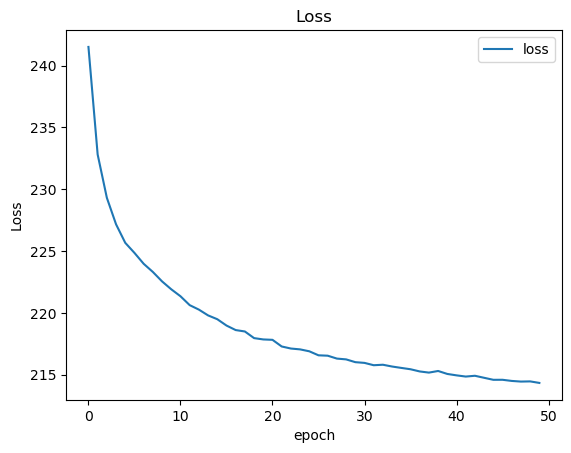

In [10]:
plt.plot(np.array(losses_auto_encode)+np.array(losses_digit_classifier))
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')
plt.show()

In [11]:
def plot_samples(samples):
    plt.figure(figsize=(28 * params['num_pic_class'],
                        len(samples) * 28))
    for epoch, images in enumerate(samples):
        for pic, image in enumerate(images):
            plt.subplot(len(samples),
                        params['num_pic_class'],
                        epoch * params['num_pic_class'] + pic + 1)
            plt.imshow(image.reshape((28, 28)), cmap="gray")
            plt.gca().xaxis.set_visible(False)
            if pic == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)

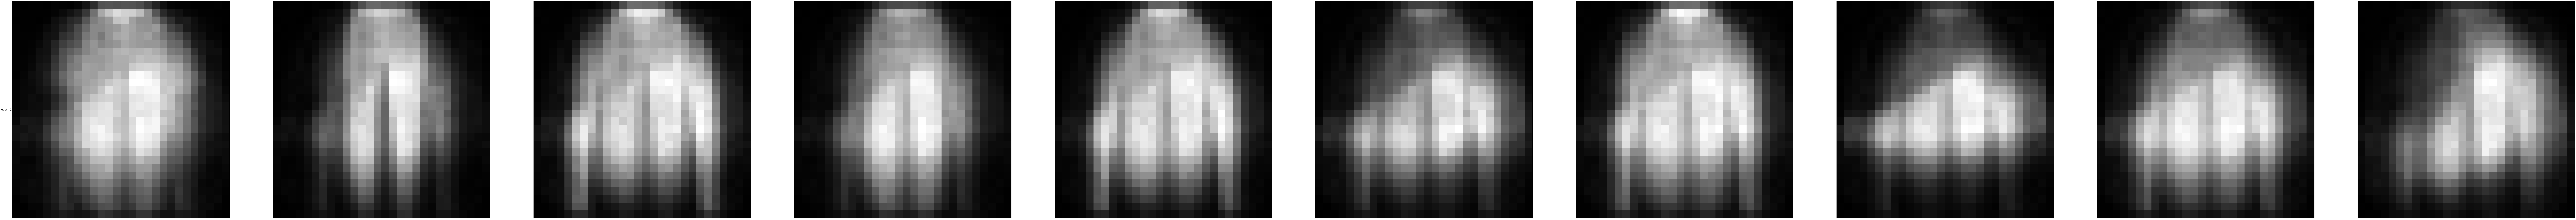

In [12]:
plot_samples([samples[0]])

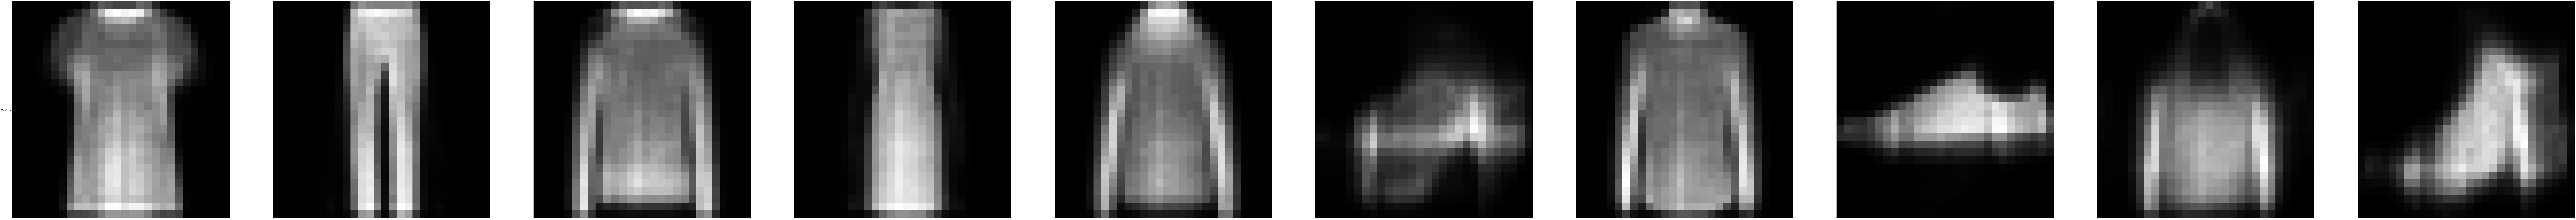

In [13]:
plot_samples([samples[10]])

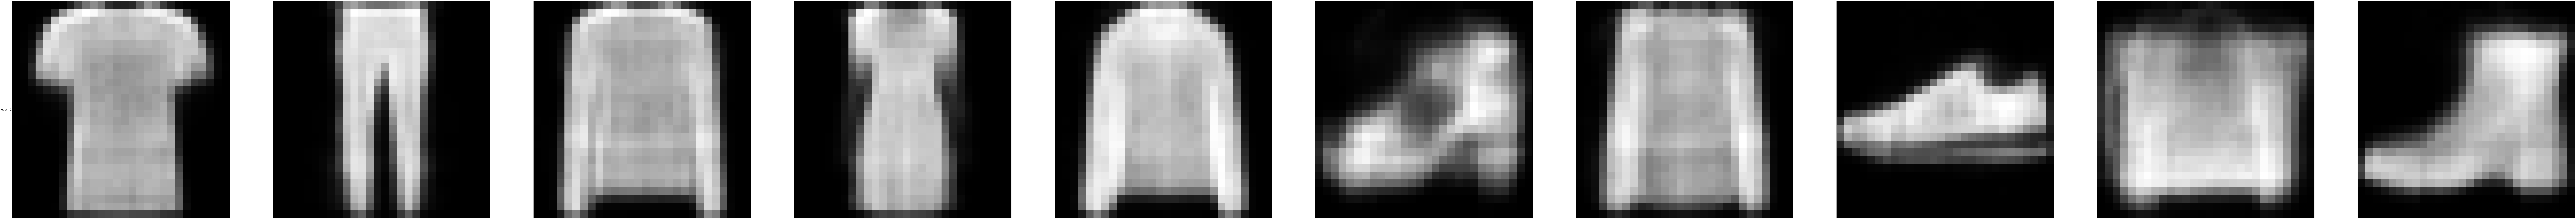

In [14]:
plot_samples([samples[20]])

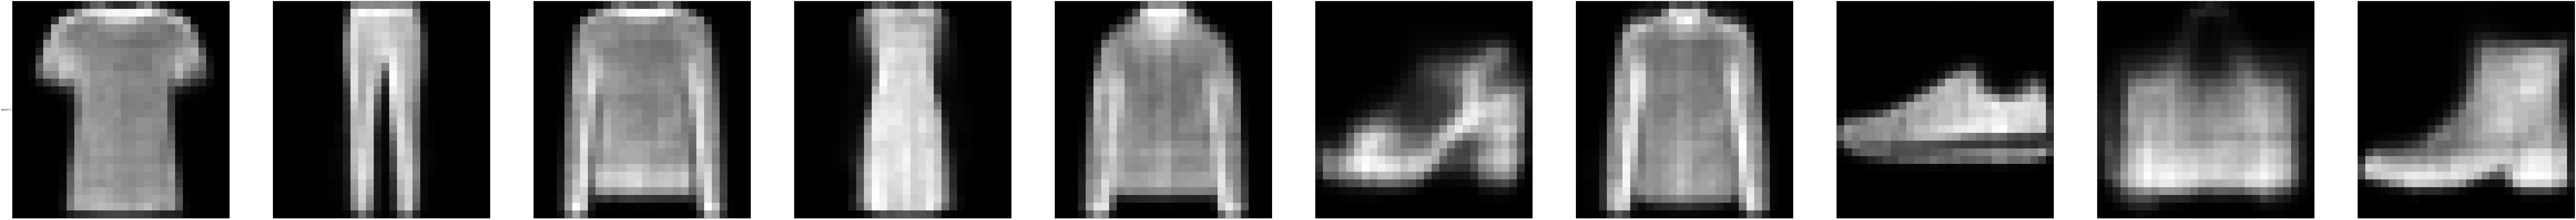

In [15]:
plot_samples([samples[30]])

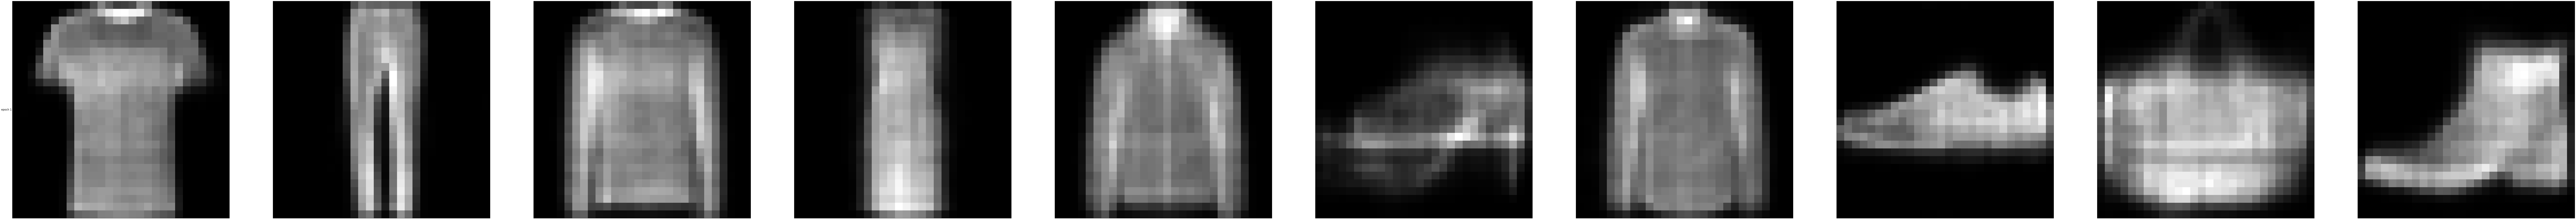

In [16]:
plot_samples([samples[40]])

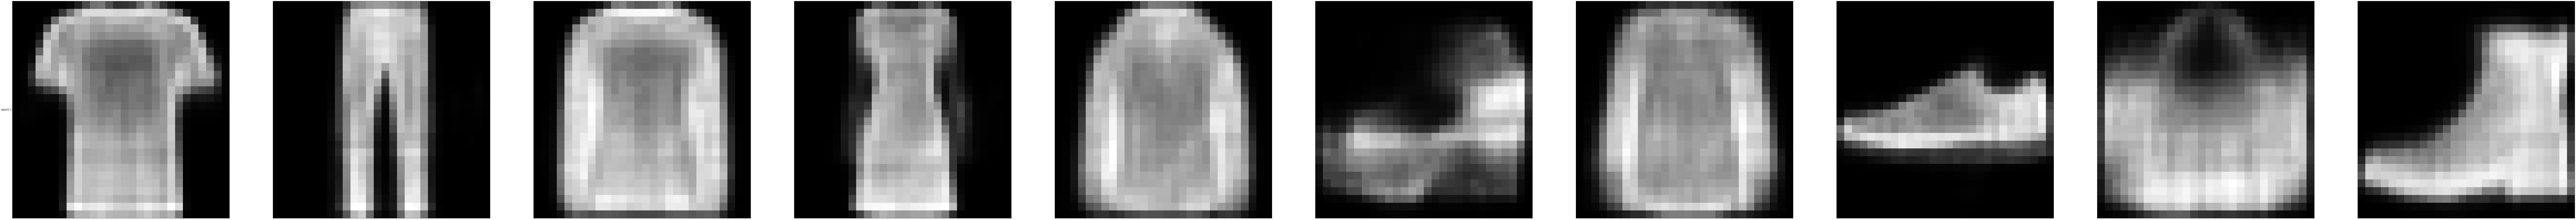

In [17]:
plot_samples([samples[48]])